In [27]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


# importing libraries and prepairing data 

In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import matplotlib.pyplot as plt

import tensorflow as tf 

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import  Flatten,Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

input_dir = "../input/chest-xray-pneumonia/chest_xray/"
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [70]:
#prepairing the generators

train_datagen = ImageDataGenerator(
                                rescale=1/255.0,
                               horizontal_flip=True,
                               zoom_range=0.2,
                               shear_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

#creating classes from directories
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=16,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        batch_size=16,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        batch_size=16,
        class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


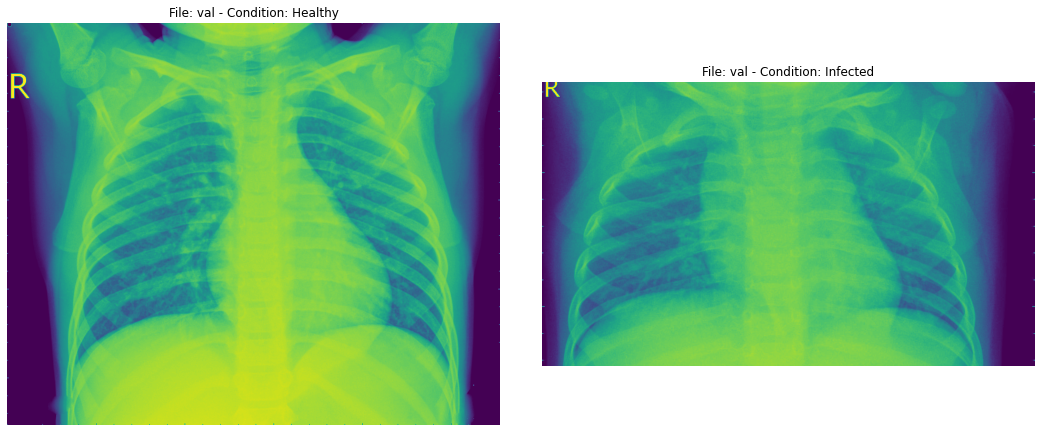

In [79]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['val']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+1].axis('off')
    ax[i+1].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]))
    ax[i+1].set_title('File: {} - Condition: Infected'.format(_set))

# building the model 

In [72]:
#initializing the model  
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

# avoiding overfitting
for layer in vgg.layers:
    layer.trainable = False #making all the layers non-trainable


x = Flatten()(vgg.output) #flattening out the last layer
predictions = Dense(2,activation='sigmoid')(x) #Dense layer to predict wether their is pneumonia or not
model = Model(inputs=vgg.input, outputs=predictions)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

hist = model.fit(train_generator,
        steps_per_epoch=25,
        epochs=25,
        validation_data=test_generator,
        validation_steps=10)

Epoch 1/25
25/25 [==============================] - 62s 2s/step - loss: 1.1528 - accuracy: 0.5860 - val_loss: 0.4011 - val_accuracy: 0.8250
Epoch 2/25
25/25 [==============================] - 61s 2s/step - loss: 0.1853 - accuracy: 0.9172 - val_loss: 0.3697 - val_accuracy: 0.8500
Epoch 3/25
25/25 [==============================] - 61s 2s/step - loss: 0.1373 - accuracy: 0.9512 - val_loss: 0.3641 - val_accuracy: 0.8875
Epoch 4/25
25/25 [==============================] - 61s 2s/step - loss: 0.1244 - accuracy: 0.9447 - val_loss: 0.2700 - val_accuracy: 0.9062
Epoch 5/25
25/25 [==============================] - 61s 2s/step - loss: 0.1103 - accuracy: 0.9497 - val_loss: 0.6085 - val_accuracy: 0.8062
Epoch 6/25
25/25 [==============================] - 61s 2s/step - loss: 0.1598 - accuracy: 0.9429 - val_loss: 0.1944 - val_accuracy: 0.9312
Epoch 7/25
25/25 [==============================] - 61s 2s/step - loss: 0.0852 - accuracy: 0.9716 - val_loss: 0.3771 - val_accuracy: 0.8687
Epoch 8/25
25/25 [==

# testing the model

The Average Training Accuracy is 0.9387999939918518


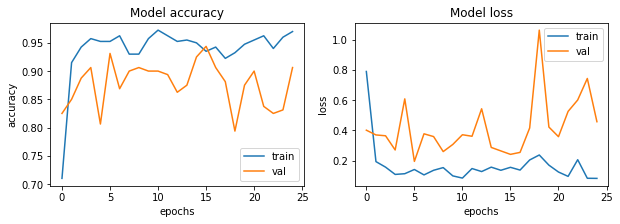

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
avg = np.mean(hist.history['accuracy'])
print('The Average Training Accuracy is', avg)


In [85]:
predict = model.predict(validation_generator)
predict=np.argmax(predict,axis=1)
print(predict)

[1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1]


# layout and design

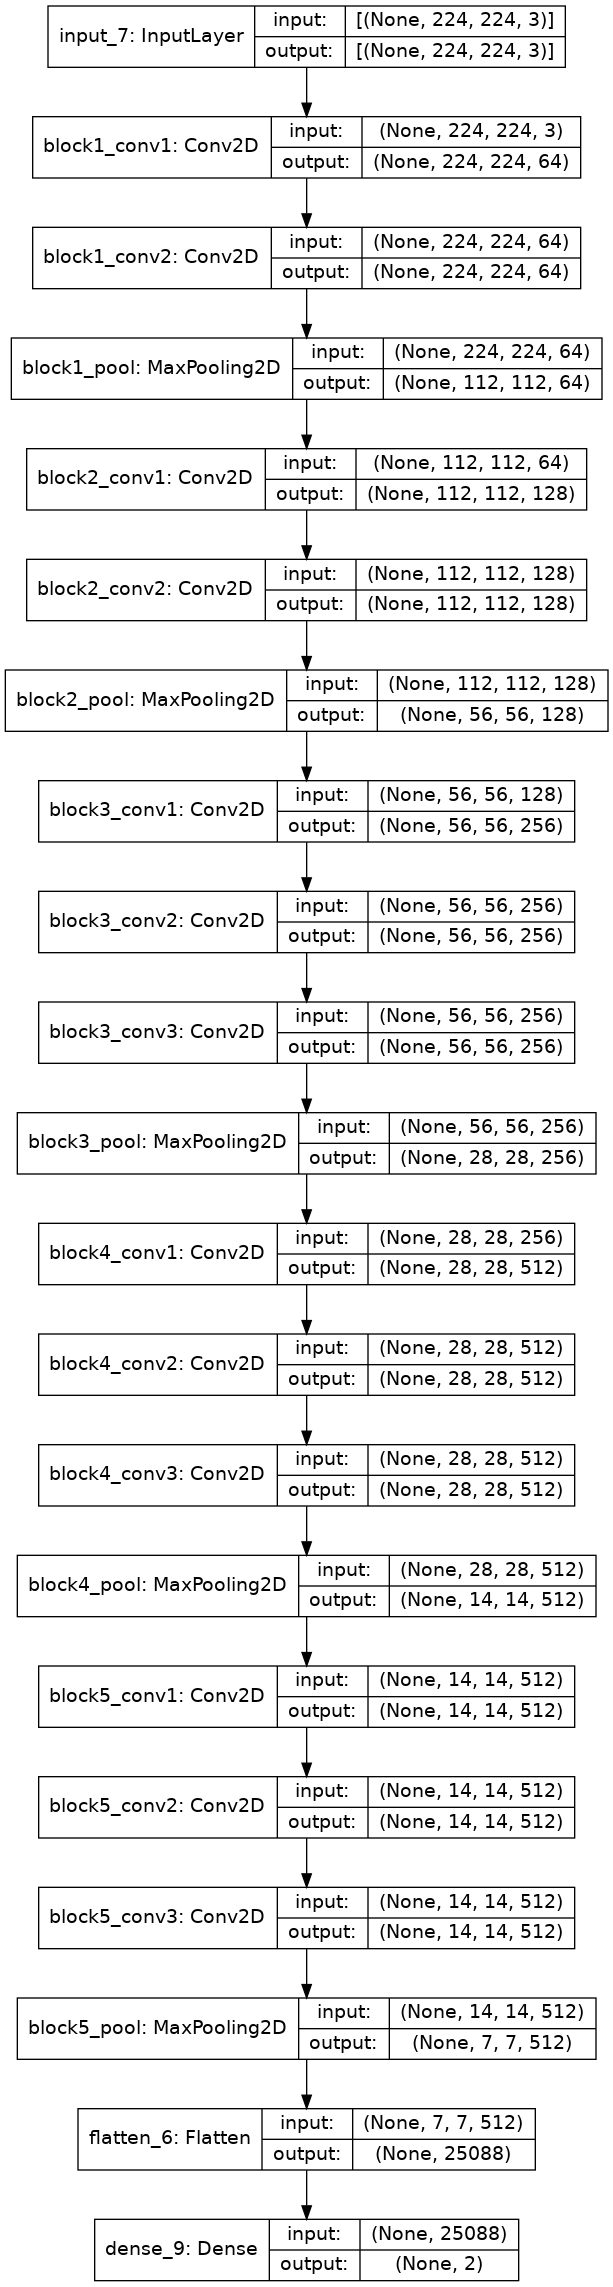

In [48]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)